# Apply and Visualize UMAP

**Gregory Way, 2019**

Apply UMAP to merged batch 1 and batch 3 data

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(umap))

source(file.path("scripts", "util.R"))

In [2]:
set.seed(12345)

In [3]:
# Load labels
file = file.path("data", "category_labels.csv")
label_df = readr::read_csv(file, col_types=readr::cols())
colnames(label_df) <- paste0("Metadata_", colnames(label_df))

label_df

Metadata_T2D_bin,Metadata_quantile_T2D,Metadata_percentile_T2D,Metadata_rank_T2D,Metadata_percentile_HOMA-IR,Metadata_rank_HOMA-IR,Metadata_IID,Metadata_category
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
0,NA,87.50,161.0,47.83,88,m164,1
1,NA,81.52,150.0,80.43,148,m246,1
1,NA,23.91,44.0,39.67,73,m252,0
0,0,38.32,70.5,93.48,172,m266,1
1,0,57.61,106.0,8.70,16,m270,0
1,NA,92.39,170.0,79.35,146,m272,1
0,NA,93.48,172.0,16.85,31,m276,0


In [4]:
file <- file.path("data", "batch1_batch3_combined_normalized_variable_selected.tsv")

cp_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Batch = readr::col_character(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_cell_line = readr::col_character(),
    Metadata_patient = readr::col_character(),
    Metadata_FFA = readr::col_character(),
    Metadata_diff_day = readr::col_character()
)

df <- readr::read_tsv(file, col_types = cp_cols) %>%
    dplyr::filter(Metadata_FFA == 0)

recode_patient <- paste0("m", gsub("PAC_", "", df$Metadata_patient))
df$Metadata_patient <- recode_patient
df$Metadata_patient_merge <- recode_patient

df <- label_df %>%
    dplyr::inner_join(df, by = c("Metadata_IID" = "Metadata_patient_merge"), keep_all = TRUE)

dim(df)
head(df, 2)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

[1] 290 697

Metadata_T2D_bin,Metadata_quantile_T2D,Metadata_percentile_T2D,Metadata_rank_T2D,Metadata_percentile_HOMA-IR,Metadata_rank_HOMA-IR,Metadata_IID,Metadata_category,Metadata_Plate,Metadata_Well,⋯,Nuclei_Correlation_K_DNA_Mito,Cells_Texture_Correlation_AGP_5_00,Nuclei_Granularity_13_DNA,Nuclei_Intensity_LowerQuartileIntensity_BODIPY,Cytoplasm_Intensity_MassDisplacement_Mito,Cytoplasm_Texture_InfoMeas1_AGP_5_02,Cells_Correlation_K_AGP_DNA,Cells_Mean_SmallBODIPYObjects_Granularity_12_BODIPY,Cytoplasm_RadialDistribution_RadialCV_AGP_2of4,Nuclei_AreaShape_MinFeretDiameter
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,NA,87.5,161,47.83,88,m164,1,BR00101080,B07,⋯,0.3711196,-1.2972831,1.105599,-1.80203900,-1.4871065,1.082764,-0.8330715,0.5781994,-1.124198,-0.0393844
0,NA,87.5,161,47.83,88,m164,1,BR00101080,B08,⋯,0.3047975,0.4845052,-0.502055,0.05419395,0.2375319,0.728483,0.4137264,0.1433681,-1.284908,-0.9143310


In [5]:
metadata_df <- df %>%
    dplyr::select(dplyr::starts_with("Metadata_"))

cp_df <- df %>%
    dplyr::select(-dplyr::starts_with("Metadata_"))

In [6]:
# Apply UMAP
umap_file <- file.path("umap_shiny", "data", "combined_batch1_batch3_umap_with_metadata.tsv")

if (!file.exists(umap_file)) {
    cp_umap <- umap(as.matrix(cp_df))
    cp_umap_df <- cp_umap$layout %>%
        dplyr::as_tibble()

    colnames(cp_umap_df) <- c("umap_x", "umap_y")

    # Merge with metadata
    cp_umap_df <- cp_umap_df %>%
        dplyr::bind_cols(metadata_df)

    # Process Columns
    cp_umap_df <- cp_umap_df %>%
        dplyr::select(umap_x,
                      umap_y,
                      Metadata_Plate,
                      Metadata_Well,
                      Metadata_cell_line,
                      Metadata_patient,
                      Metadata_diff_day,
                      Metadata_Batch,
                      Metadata_T2D_bin,
                      Metadata_quantile_T2D,
                      Metadata_percentile_T2D,
                      Metadata_rank_T2D,
                      `Metadata_percentile_HOMA-IR`,
                      `Metadata_rank_HOMA-IR`,
                      `Metadata_IID`,
                      `Metadata_category`) %>%
        dplyr::rename(x = umap_x,
                      y = umap_y,
                      Plate = Metadata_Plate,
                      Well = Metadata_Well,
                      Cell_Line = Metadata_cell_line,
                      Patient = Metadata_patient,
                      Day = Metadata_diff_day,
                      Batch = Metadata_Batch,
                      `T2D Bin` = Metadata_T2D_bin,
                      `T2D Quantile` = Metadata_quantile_T2D,
                      `T2D Percentile` = Metadata_percentile_T2D,
                      `T2D Rank` = Metadata_rank_T2D,
                      `HOMA-IR Percentile` = `Metadata_percentile_HOMA-IR`,
                      `HOMA-IR Rank` = `Metadata_rank_HOMA-IR`,
                      `IID` = `Metadata_IID`,
                      `Category` = `Metadata_category`)
    
    cp_umap_df$Day <- dplyr::recode(cp_umap_df$Day, "15+iso" = "15")
    cp_umap_df$Day <- factor(cp_umap_df$Day, levels = sort(as.numeric(paste(unique(cp_umap_df$Day)))))
    
    readr::write_tsv(cp_umap_df, umap_file)
} else {
    cp_umap_df <- readr::read_tsv(umap_file, col_types = readr::cols())
}

head(cp_umap_df, 2)

x,y,Plate,Well,Cell_Line,Patient,Day,Batch,T2D Bin,T2D Quantile,T2D Percentile,T2D Rank,HOMA-IR Percentile,HOMA-IR Rank,IID,Category
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
3.08423853,0.8756215,BR00101080,B07,sc,m164,3,batch_one,0,NA,87.5,161,47.83,88,m164,1
-0.02893264,2.6357012,BR00101080,B08,vc,m164,3,batch_one,0,NA,87.5,161,47.83,88,m164,1


## Visualize UMAP Compression

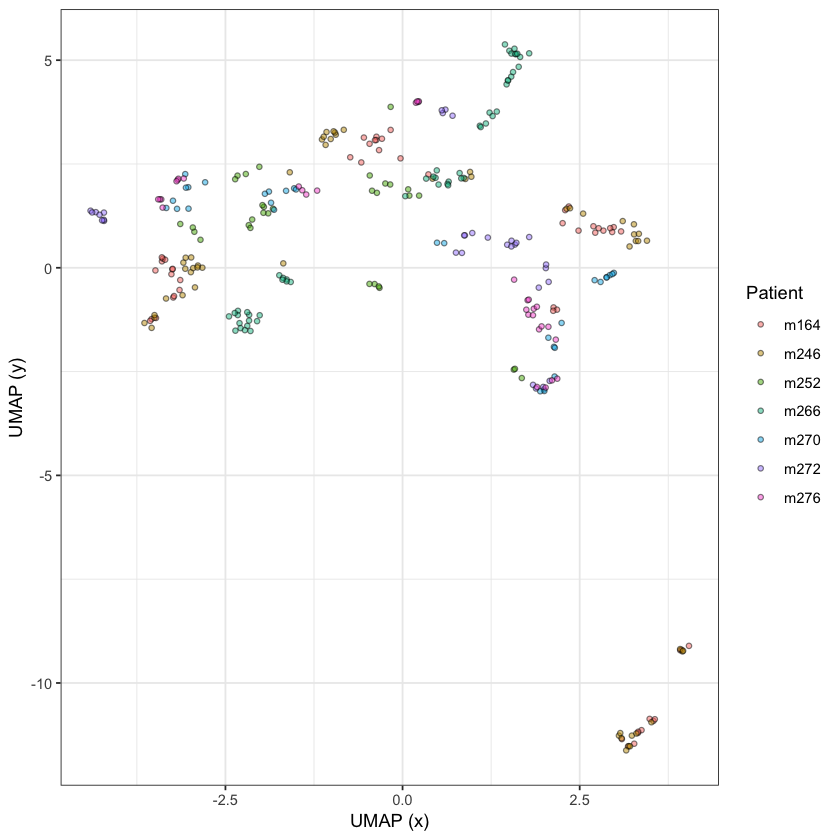

In [7]:
patient_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Patient),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Patient") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")

patient_gg

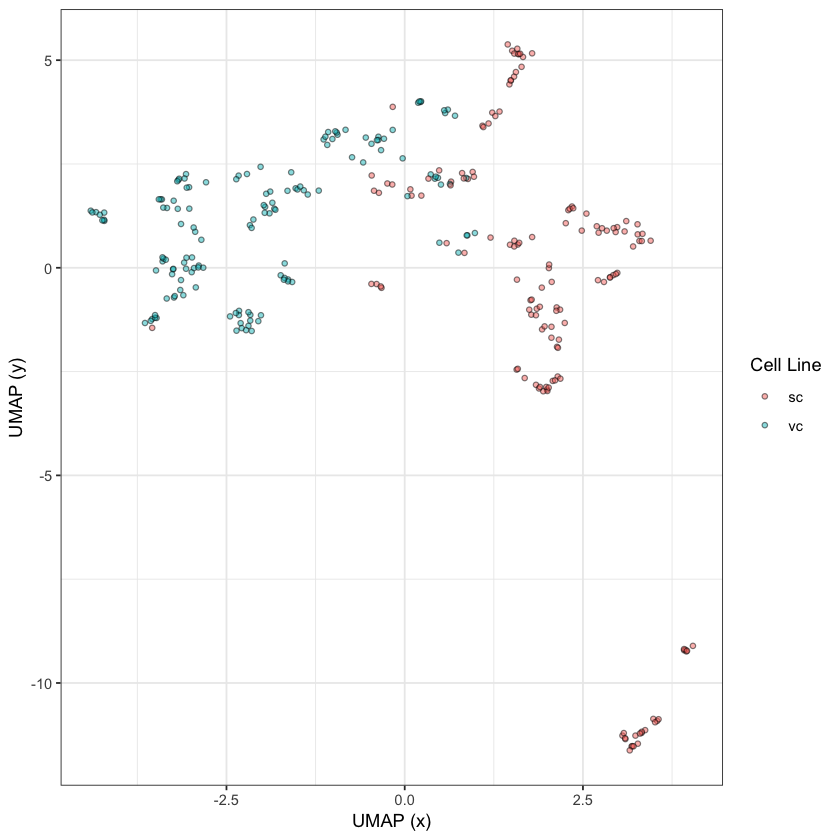

In [8]:
cell_line_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Cell_Line),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Cell Line") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")

cell_line_gg

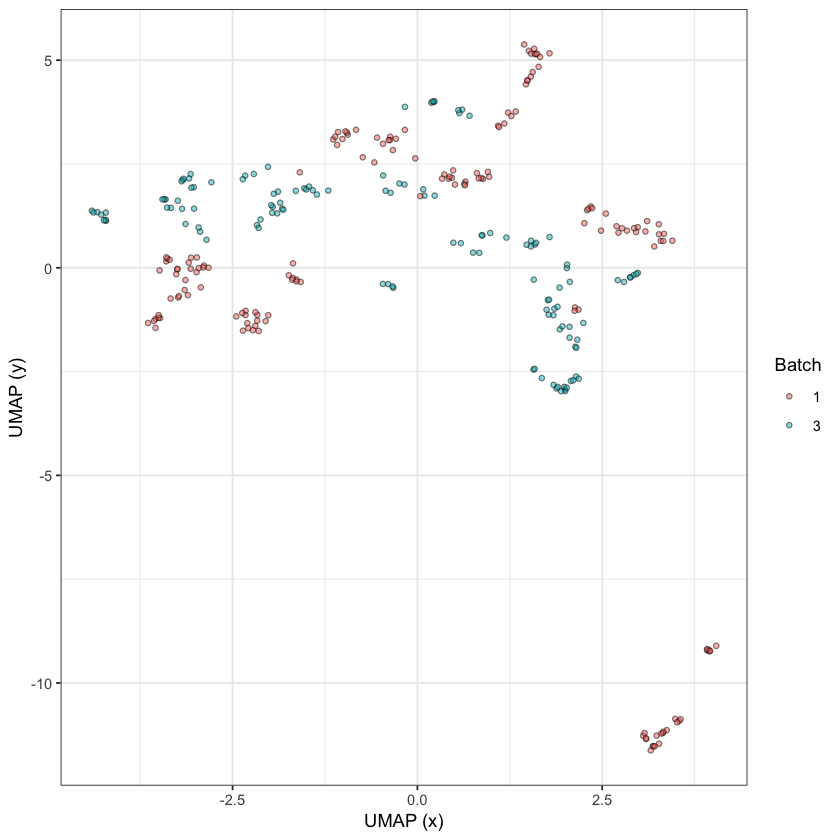

In [9]:
batch_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Batch),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Batch",
                        labels = c("batch_one" = "1",
                                   "batch_three" = "3")) +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
batch_gg

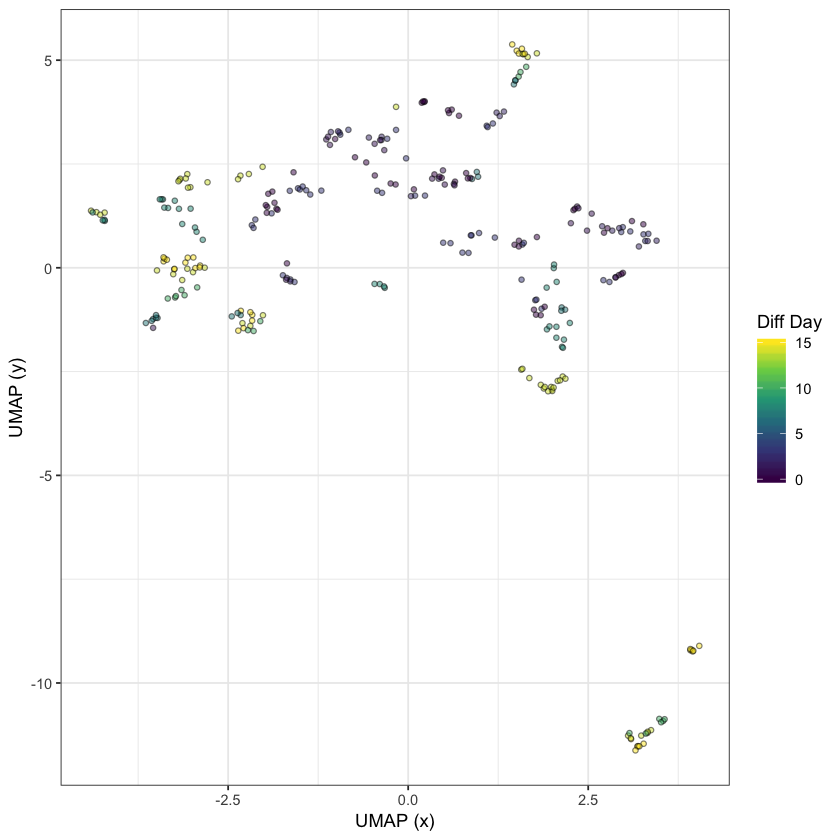

In [10]:
day_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = as.numeric(paste(Day))),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_viridis_c(name = "Diff Day") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
day_gg

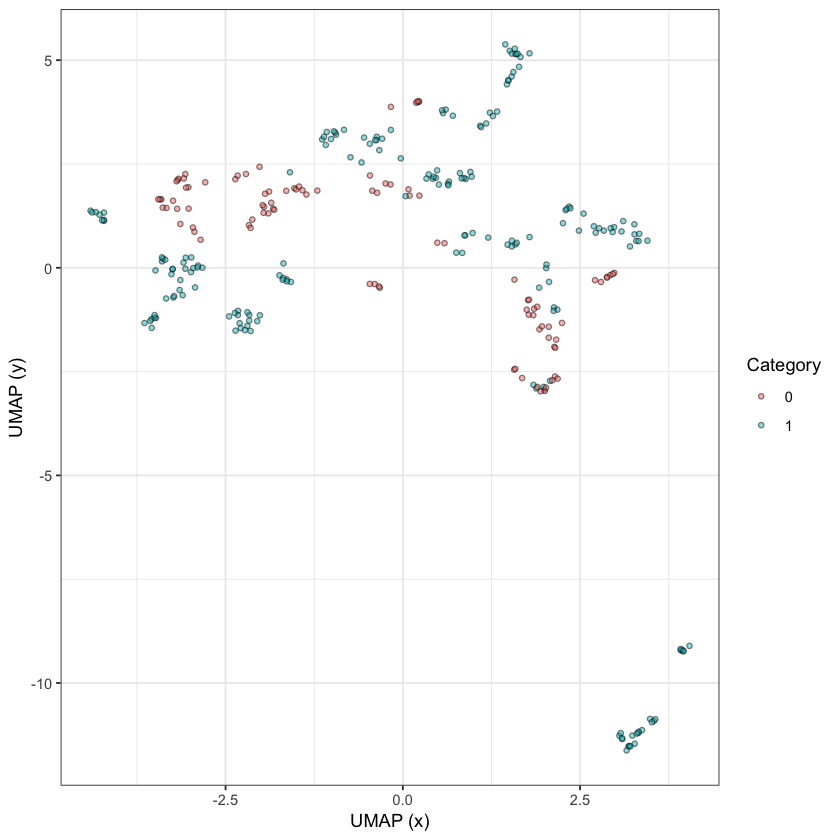

In [11]:
category_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = factor(Category)),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Category") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
category_gg

## Combine Plots into Single Cowplot

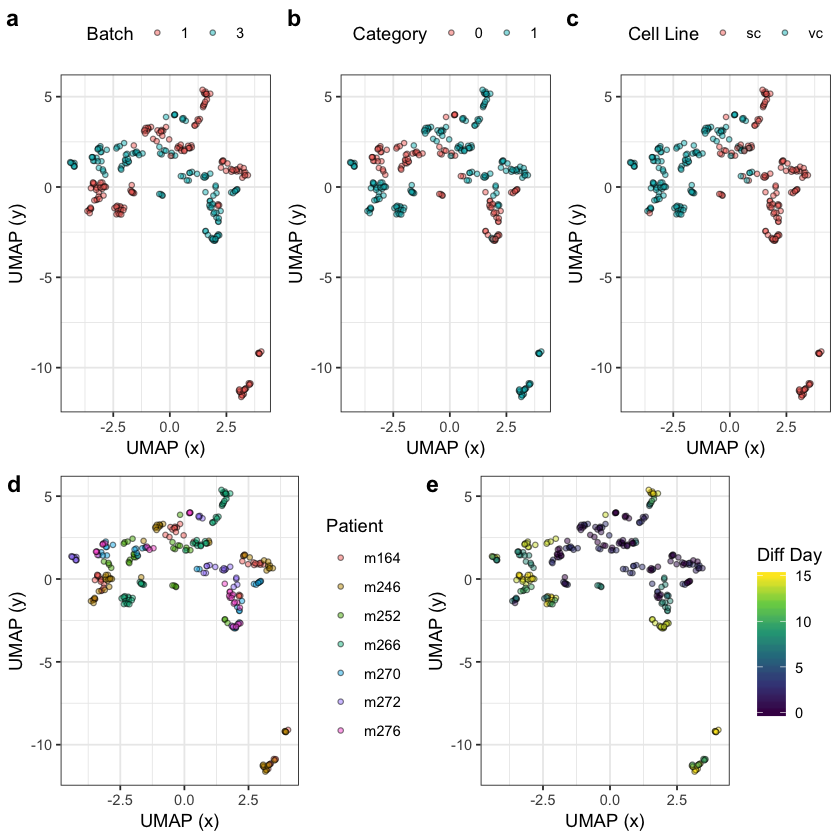

In [12]:
top_row <- (
    cowplot::plot_grid(
        batch_gg + theme(legend.position = "top"),
        category_gg + theme(legend.position = "top"),
        cell_line_gg + theme(legend.position = "top"),
        labels = c("a", "b", "c"),
        ncol = 3
    )
)

bottom_row <- (
    cowplot::plot_grid(
        patient_gg,
        day_gg,
        labels = c("d", "e"),
        ncol = 2
    )
)


main_plot <- (
    cowplot::plot_grid(
        top_row,
        bottom_row,
        ncol = 1,
        nrow = 2,
        rel_heights = c(1, 0.8)
    )
)

main_plot

In [13]:
for(extension in c('.png', '.pdf')) {
    sup_file <- paste0("umap_metadata_batch1_batch3_combined", extension)
    sup_file <- file.path("figures", sup_file)
    cowplot::save_plot(filename = sup_file,
                       plot = main_plot,
                       base_height = 130,
                       base_width = 155,
                       unit = "mm")
}

## Time Points in Visceral and Subcutaneous Tissue

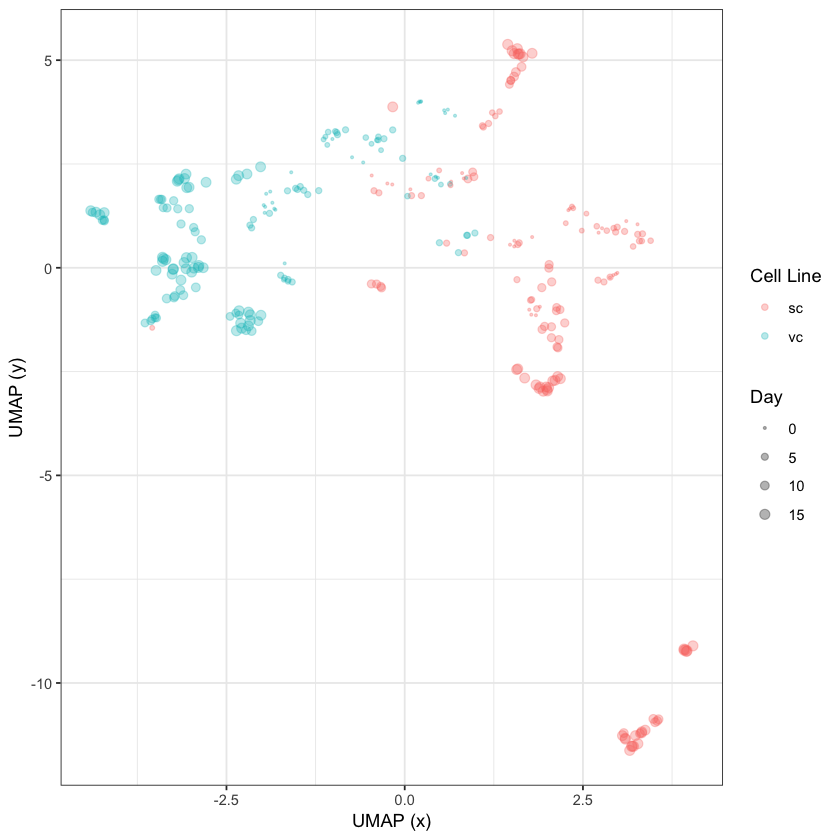

In [14]:
umap_full_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(color = Cell_Line,
                   size = as.numeric(paste(Day))),
               alpha = 0.3) +
    theme_bw() +
    scale_size_continuous(name = "Day",
                          range = c(0.5, 2.5)) +
    scale_color_discrete(name = "Cell Line") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)") +
    theme(strip.text.x = element_text(size = 10),
          strip.text.y = element_text(size = 7),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

umap_full_gg

In [15]:
extensions <- c(".png", ".pdf", ".svg")
output_filebase <- file.path("figures", "umap_batch1_batch3_day_line_batch")

save_figure(umap_full_gg, output_filebase, extensions, height = 5, width = 6, dpi = 500)

In [16]:
table(cp_umap_df$Day)


 0  1  2  3  7  8 10 14 15 
50 18 18 50 18 32 18 50 36 

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

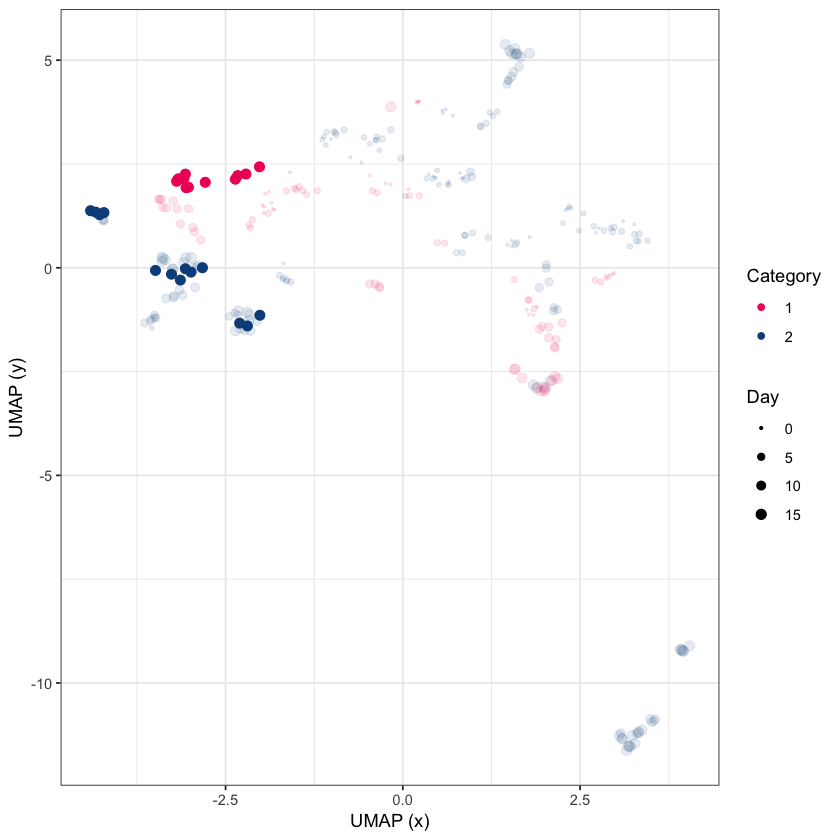

In [17]:
cp_umap_df <- cp_umap_df %>%
    dplyr::mutate(
        day_14_only = ifelse(
            (
                cp_umap_df$Day == 14
            ) & (
                cp_umap_df$Cell_Line == "vc"
            ),
            "day_14", "not_day_14"
        ),
        late_days_only = ifelse(
            (
                cp_umap_df$Day %in% c(10, 14, 15)
            ) & (
                cp_umap_df$Cell_Line == "vc"
            ),
            "late_day", "early_day"
        )
    )

umap_day14_vc_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(color = paste(Category),
                   alpha = day_14_only,
                   size = as.numeric(paste(Day)))) +
    theme_bw() +
    scale_size_continuous(name = "Day",
                          range = c(0.5, 2.5)) +
    scale_color_manual(name = "Category",
                         values = c("0" = "#EF1665", 
                                    "1" = "#0A4E8A"),
                         labels = c("0" = "1",
                                    "1" = "2")) +
    scale_alpha_manual(name = "", 
                       values = c(1, 0.1), 
                       guide = 'none') +
    xlab("UMAP (x)") +
    ylab("UMAP (y)") +
    theme(strip.text.x = element_text(size = 10),
          strip.text.y = element_text(size = 7),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    guides(color = guide_legend(order = 1))

extensions <- c(".png", ".pdf", ".svg")
output_filebase <- file.path("figures", "umap_batch1_batch3_day_line_batch_day14_highlight")

save_figure(umap_day14_vc_gg, output_filebase, extensions, height = 5, width = 6, dpi = 500)

umap_day14_vc_gg

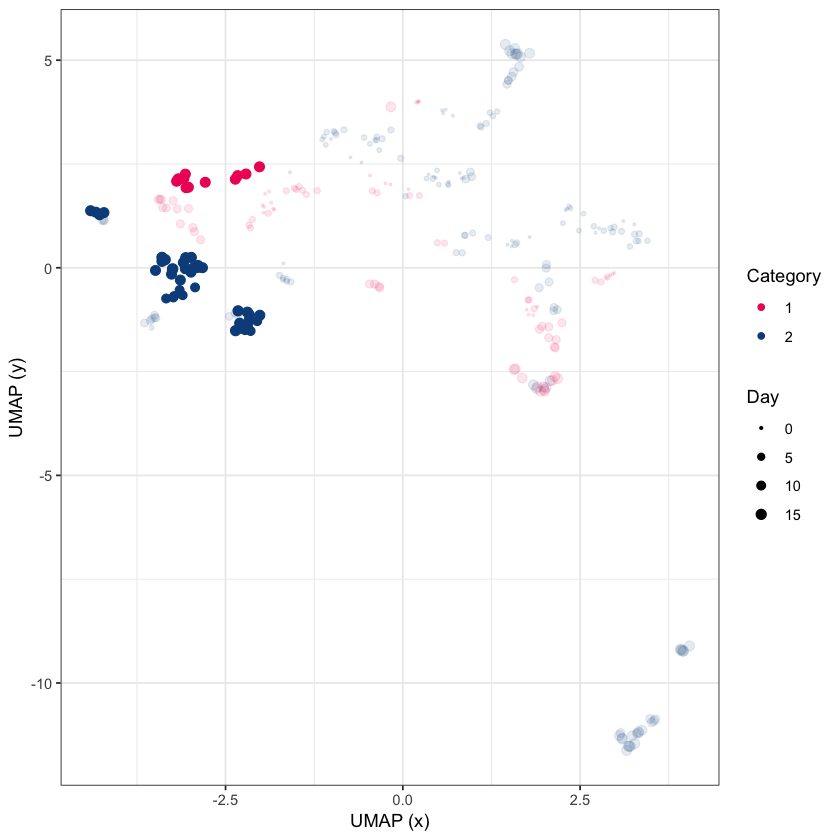

In [18]:
umap_lateday_vc_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(color = paste(Category),
                   alpha = late_days_only,
                   size = as.numeric(paste(Day)))) +
    theme_bw() +
    scale_size_continuous(name = "Day",
                          range = c(0.5, 2.5)) +
    scale_color_manual(name = "Category",
                         values = c("0" = "#EF1665", 
                                    "1" = "#0A4E8A"),
                         labels = c("0" = "1",
                                    "1" = "2")) +
    scale_alpha_manual(name = "", 
                       values = c(0.1, 1), 
                       guide = 'none') +
    xlab("UMAP (x)") +
    ylab("UMAP (y)") +
    theme(strip.text.x = element_text(size = 10),
          strip.text.y = element_text(size = 7),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    guides(color = guide_legend(order = 1))

extensions <- c(".png", ".pdf", ".svg")
output_filebase <- file.path("figures", "umap_batch1_batch3_day_line_batch_lateday_highlight")

save_figure(umap_lateday_vc_gg, output_filebase, extensions, height = 5, width = 6, dpi = 500)


umap_lateday_vc_gg